# Setup Paths

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [6]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [7]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [8]:
import object_detection

# Create Label Map

In [9]:
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# Update Config For Transfer Learning

In [10]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [11]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [12]:
config

{'model': ssd {
   num_classes: 1
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   match

In [13]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [14]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [15]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

# Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

# Load Train Model From Checkpoint

In [16]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [17]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    #print(shapes,image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [18]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [28]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'],'test','Cars415.png') 

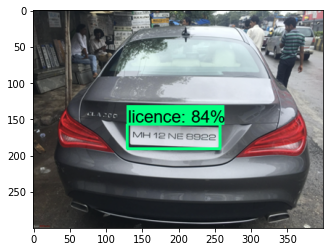

In [29]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)   

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)   
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))   
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections    

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)   

label_id_offset = 1
image_np_with_detections = image_np.copy()    

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,                   
            use_normalized_coordinates=True,  
            max_boxes_to_draw=5,              
            min_score_thresh=0.5,             
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Apply OCR to Detection

In [31]:
import easyocr

In [32]:
detection_threshold=0.4

In [34]:
image=image_np_with_detections
scores=list(filter(lambda x:x>detection_threshold,detections['detection_scores'])) 
print(scores)
boxes=detections['detection_boxes'][:len(scores)]
classes=detections['detection_classes'][:len(scores)]

[0.8407445]


In [35]:
width=image.shape[1]
height=image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Bounding box:  [0.5262648 0.3241949 0.6339171 0.6469499]
Region of interest:  [157.87943602 129.67796326 190.17512798 258.77995491]
[[([[7, 9], [125, 9], [125, 25], [7, 25]], 'MH1ZNE B922', 0.6169077001994162)]]


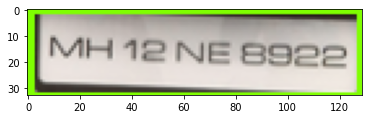

In [36]:
li=[]
regions=[]
for idx,box in enumerate(boxes):
    print("Bounding box: ",box)  
    roi=box*[height,width,height,width]     
    print("Region of interest: ",roi)   
    
    region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]       
    
    regions.append(region)
    
    plt.imshow(region)
    
    reader=easyocr.Reader(['en'])  #english
    ocr_result=reader.readtext(region)
    
    li.append(ocr_result)
    
    print(li)

In [37]:
for i in li:
    print(i)

[([[7, 9], [125, 9], [125, 25], [7, 25]], 'MH1ZNE B922', 0.6169077001994162)]


In [78]:
li

[[([[7, 9], [125, 9], [125, 25], [7, 25]], 'MH1ZNE B922', 0.6169077001994162)]]

In [38]:
for result in li:
    print(result)  

[([[7, 9], [125, 9], [125, 25], [7, 25]], 'MH1ZNE B922', 0.6169077001994162)]


# OCR Filtering Algorithm

In [39]:
region_threshold=0.1

In [40]:
region.shape

(33, 129, 3)

In [41]:
def filter_text(region,ocr_result,region_threshold):
    rectangle_size=region.shape[0]*region.shape[1]     
    
    plate=[]
    
    for result in ocr_result:
        length=np.sum(np.subtract(result[0][1],result[0][0]))  
        height=np.sum(np.subtract(result[0][2],result[0][1]))  
        
        if length*height/rectangle_size>region_threshold:  
            plate.append(result[1])   
    return plate

In [42]:
li

[[([[7, 9], [125, 9], [125, 25], [7, 25]], 'MH1ZNE B922', 0.6169077001994162)]]

In [43]:
for i in li:
    print(i[0][1])

MH1ZNE B922


In [44]:
    
for i in range(len(scores)):
    print(filter_text(regions[i],li[i],region_threshold))
    

['MH1ZNE B922']


In [47]:
for i in li:
    print(i)

[([[7, 9], [125, 9], [125, 25], [7, 25]], 'MH1ZNE B922', 0.6169077001994162)]


# Bringing together

In [48]:

def ocr_it(image,detections,detection_threshold,region_threshold):
    li=[]    
    regions=[] 
    licence=[] 
    scores=list(filter(lambda x:x>detection_threshold,detections['detection_scores']))
    boxes=detections['detection_boxes'][:len(scores)]
    classes=detections['detection_classes'][:len(scores)]
    
    width=image.shape[1]
    height=image.shape[0]
    
        
    for idx,box in enumerate(boxes):
       
        roi=box*[height,width,height,width]
       
        region=image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]   
        regions.append(region)
        reader=easyocr.Reader(['en'])  
        ocr_result=reader.readtext(region)
        li.append(ocr_result)
       
    for i in range(len(scores)):
        text=filter_text(regions[i],li[i],region_threshold)
        licence.append(text)
        
        plt.imshow(cv2.cvtColor(regions[i],cv2.COLOR_BGR2RGB))
        
        print(licence)
        
        return licence,regions
    

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[['MH1ZNE B922']]


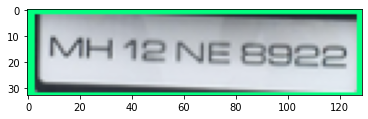

In [49]:
text,region=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)   #not the image command but image_np_with_dimensions

In [50]:
text

[['MH1ZNE B922']]

# Saving Results

In [51]:
import csv
import uuid

In [52]:
from datetime import datetime

In [53]:
now = datetime.now()

In [54]:
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("date and time =", dt_string)	

date and time = 2022/04/08 14:45:20


In [55]:
'{}.jpg'.format(uuid.uuid1())

'6b137186-b71c-11ec-afe5-d8d090269def.jpg'

In [56]:
def save_results(text,region,csv_filename,folder_path,full_path):
    img_name='{}.jpg'.format(uuid.uuid1())
    
    cv2.imwrite(os.path.join(folder_path,img_name),region)
    
    
    sav=image_np_with_detections
    cv2.imwrite(os.path.join(full_path,img_name),sav)
    
    with open(csv_filename,mode='a',newline='') as f:
        dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
        # print("date and time =", dt_string) For printing the time and date 
        csv_writer=csv.writer(f,delimiter=',',quotechar='"',quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow([img_name,text[i],dt_string])       

In [57]:
for i in text:
    print(i)

['MH1ZNE B922']


In [58]:
for i in range(len(scores)):
    save_results(text[i],region[i],'detection_results.csv','Detection_Images','full_image')

In [59]:
dt_string

'2022/04/08 14:45:20'

# Real Time Detections from your Webcam

In [ ]:
cap=cv2.VideoCapture("C:/Users/sai ganesh/Web/RecordFiles/2022-04-07/video1.mp4")

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(cap.isOpened())
count=0

while cap.isOpened(): 
    ret, frame = cap.read()
    
    if ret:
        count+=3
        cap.set(cv2.CAP_PROP_POS_FRAMES,count)
        image_np = np.array(frame)
    
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)
    
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                 for key, value in detections.items()}
        detections['num_detections'] = num_detections

        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.51,
                agnostic_mode=False)
        try:
            texts,region1=ocr_it(image_np_with_detections,detections,detection_threshold,region_threshold)
            for i in range(len(texts)):
                save_results(texts[i],region1[i],'realtimeresults.csv','Detection_Images','full_image')
        except:
            pass
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
  